Welcome ! Join in, on the fun ride of Data sciency project. Trust me its a roller coaster, coz the target is not smooth at all :)

## Whats the deal?

The deal is two determine whether an account churns away or not. When do the company intervene to check on those accounts.

Ok, so What do we know in short:

    1. Bundle of Masked data(Features) :- Deal with it (EDA) (Scaling and basic Data prep has already been done)
    2. Highly imbalanced data          :- Mostly 0- Dont churn, 1- Churn away
    3. Acc id and weekly start date    :- When they logged in, repeats once every week
    4. Sampling needs to be done and split the test train

## Process:
    1. Gather sense of whats going on in data ( Deal with masked data - EDA and feature engineering)
    2. Try right of the bat model and complete the loop.(XGB)
    3. Preprocess and split (Split on the accounts instead of the rows)
    4. Undersample or over sample (Correlation , churn detection, Dimensionality reduction)
    5. Testing (LR,KNN,Decision Tree, SVM)
   


In [1]:
# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold,StratifiedKFold
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')
from pylab import rcParams
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Load the data and see how it looks like. Alright, I get it, first impression of the data doesnt give you much but try and get to know it more :)

In [22]:
df_train = pd.read_csv("Train_Set.csv")
print(df_train.head())
print(df_train.shape)
df_test = pd.read_csv('Test_Set.csv')
print(df_test.shape)

   account_id week_start_date  feature1  feature2   feature3  feature4  \
0    100559.0      2018-09-03       0.0       0.0   0.000000       0.0   
1    101026.0      2018-09-03       0.0       0.0   0.000000       0.0   
2    101026.0      2018-09-10       0.0       0.0  86.666667       0.0   
3    101026.0      2018-09-17       0.0       0.0  -0.076046       0.0   
4    101026.0      2018-09-24       0.0       0.0  -0.987654       0.0   

   feature5  feature6  feature7  feature8  ...  feature54  feature55  \
0       0.0       0.0       0.0       0.0  ...        0.0   0.000000   
1       0.0       0.0       0.0       0.0  ...        0.0   0.000000   
2       0.0       0.0       0.0       0.0  ...        0.0   0.333333   
3       0.0       0.0       0.0       0.0  ...        0.0   0.000000   
4       0.0       0.0       0.0       0.0  ...        0.0   0.000000   

   feature56  feature57  feature58  feature59  feature60  feature61  \
0        0.0        0.0        0.0        0.0      

In [3]:
# df_train.info()
#See if there are any null values or not
df_train.isnull().sum().max()

0

Instead of having multiple dates asscoiated with each account, I decided to create Time_in_Status which gives you how long was an account asscociated with the firm.

In [23]:
# see the time spent by each account 
df_train['week_start_date'] =  pd.to_datetime(df_train['week_start_date'])
df_train = df_train.sort_values(['account_id', 'week_start_date'])
df_train['Time_in_Status'] = df_train.groupby('account_id')['week_start_date'].diff()
df_train['Time_in_Status'].value_counts()

7 days      88596
0 days      23411
371 days        3
350 days        1
154 days        1
287 days        1
28 days         1
21 days         1
14 days         1
Name: Time_in_Status, dtype: int64

1. Added Time_in_Status into the columns 
2. Changed its location to first column
3. Dropped week_start_date column 

In [24]:
# df=df_train.drop(['week_start_date'],axis=1)
df_train['Time_in_Status'] = df_train.apply(lambda row: row.Time_in_Status.days, axis=1)

In [25]:
#Sample on accountid 
new_df = df_train.groupby('account_id').apply(lambda x: x.sample(frac=1,replace=True)).reset_index(drop = True)

In [26]:
col=df_train.columns.tolist()


In [27]:
col=col[-1:]+col[:-1]

In [28]:
df_train=df_train[col]

In [29]:
df_train=df_train.drop(['week_start_date'],axis=1)

## Lets start with the major EDA !

Lets see how many featues do we have and what is the type of the features ?

In [10]:
columns =[c for c in df_train.columns if 'feature' in c]
print("No of features {}".format(len(columns)))

print("The type of features:")
print(df_train[columns].dtypes.value_counts())

No of features 62
The type of features:
float64    62
dtype: int64


How about we see our target variable distribution?

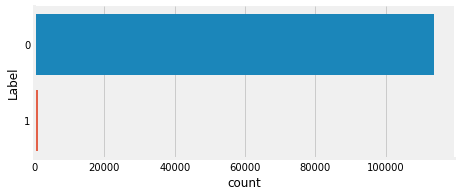

In [11]:
# Distribution of Target variable
ax = sns.catplot(y="Label", kind="count", data=df_train, height=2.6, aspect=2.5, orient='h')

### Oh Boy! 
Our target variable is very imbalanced, no worries, lets see whats the exact value of 0's and 1's

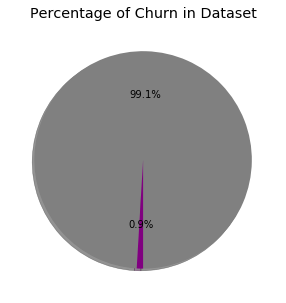

0    113630
1      1076
Name: Label, dtype: int64


In [12]:
#Check what percentage of customers were churned/when do we intervene
sizes = df_train['Label'].value_counts(sort = True)
colors = ["grey","purple"] 
rcParams['figure.figsize'] = 5,5
# Plot
plt.pie(sizes, explode=None, labels=None, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=270,)
plt.title('Percentage of Churn in Dataset')
plt.show()
print(sizes)

Lets gather info about number of rows and Columns, any missing values and Unique values per columns.

In [13]:
print ("Rows     : " ,df_train.shape[0])
print ("Columns  : " ,df_train.shape[1])
print ("\nMissing values :  ", df_train.isnull().sum().values.sum())
print ("\nUnique values :  \n",df_train.nunique())

Rows     :  114706
Columns  :  66

Missing values :   2690

Unique values :  
 Time_in_Status        9
account_id         2690
week_start_date      83
feature1            912
feature2             93
                   ... 
feature59           453
feature60           513
feature61           198
feature62          2214
Label                 2
Length: 66, dtype: int64


Ahh, becasue of the new variable creation, some values difference gave Nan bacause they existed once, so we couldnt take a difference. Lets fill them with 0 values!

In [14]:
df_train['Time_in_Status'].fillna(0, inplace=True)

Lets check out if there are any binary /Constant features. Generlly they would have a single value all across.

In [17]:
#BInary features and Constant features
counts = [[], [], []]
for c in columns:
    typ = df_train[c].dtype
    uniq = len(np.unique(df_train[c]))
    if uniq == 1: counts[0].append(c)
    elif uniq == 2 and typ == np.int64: counts[1].append(c)
    else: counts[2].append(c)

print('Constant features: {} Binary features: {} Categorical features: {}\n'.format(*[len(c) for c in counts]))

print('Constant features:', counts[0])
print('Categorical features:', counts[2])

Constant features: 0 Binary features: 0 Categorical features: 62

Constant features: []
Categorical features: ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15', 'feature16', 'feature17', 'feature18', 'feature19', 'feature20', 'feature21', 'feature22', 'feature23', 'feature24', 'feature25', 'feature26', 'feature27', 'feature28', 'feature29', 'feature30', 'feature31', 'feature32', 'feature33', 'feature34', 'feature35', 'feature36', 'feature37', 'feature38', 'feature39', 'feature40', 'feature41', 'feature42', 'feature43', 'feature44', 'feature45', 'feature46', 'feature47', 'feature48', 'feature49', 'feature50', 'feature51', 'feature52', 'feature53', 'feature54', 'feature55', 'feature56', 'feature57', 'feature58', 'feature59', 'feature60', 'feature61', 'feature62']


As all of the variables are Categorical(NOT binary or constant), lets do a Univariate analysis on them and see how do they distribute over, shall we ?

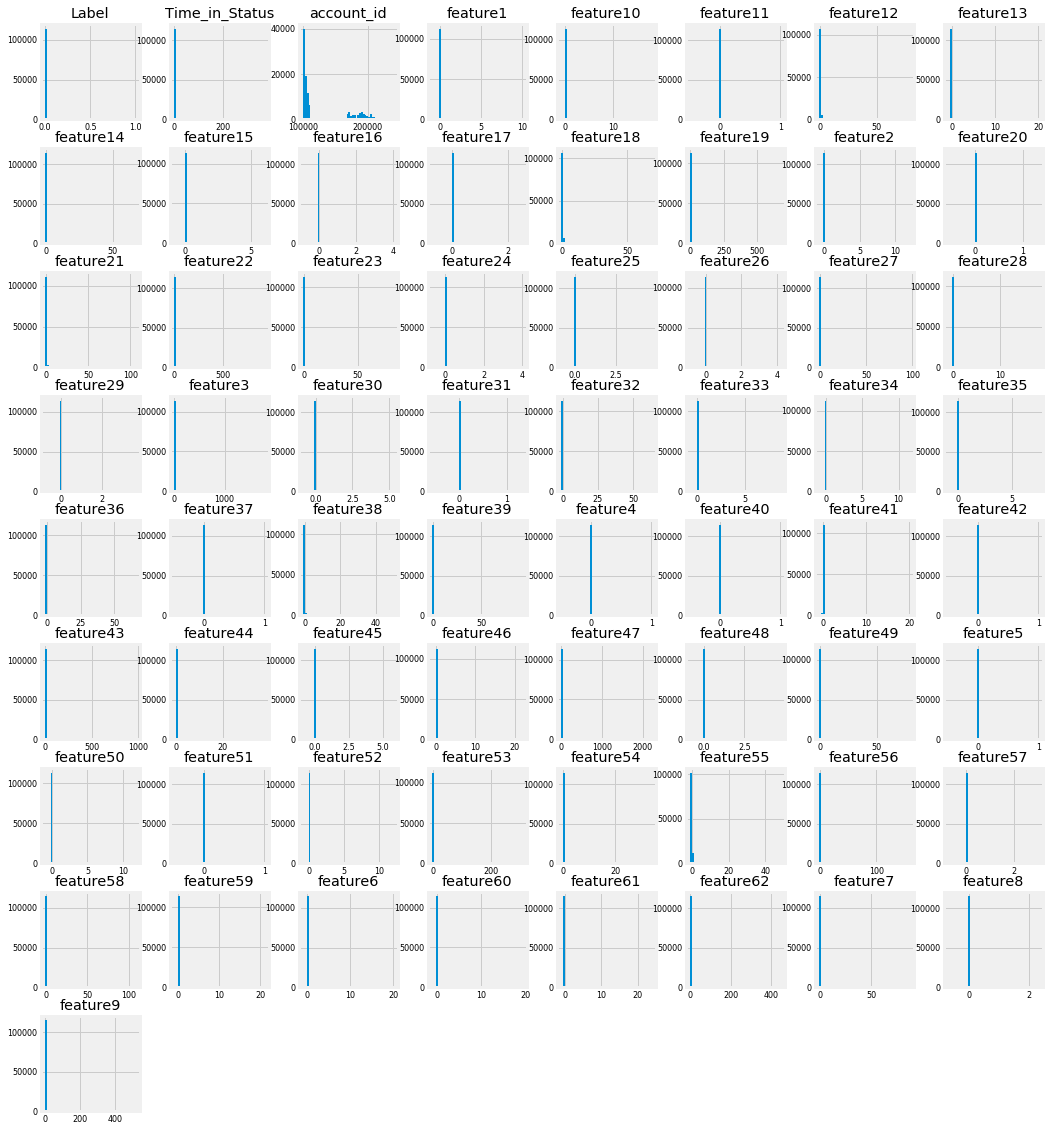

In [18]:
#Univariate 
df_train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Lets see if there is any strong correlation between our variables and target(Corr >0.5)

In [19]:
# Strong correlation (if any)
df_num = df_train.select_dtypes(include = ['float64', 'int64'])
df_num_corr = df_num.corr()['Label'][:-1] # -1 because the latest row is Label
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Label:\n{}".format(len(golden_features_list), golden_features_list))

There is 0 strongly correlated values with Label:
Series([], Name: Label, dtype: float64)


As there was none strong correlations, now lets try and see how does each variable pans out accross target variable.
Its fancily called, Bivariate analysis.

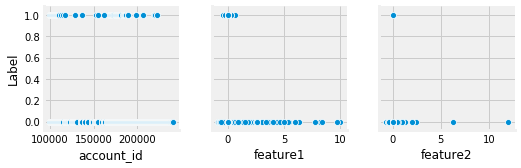

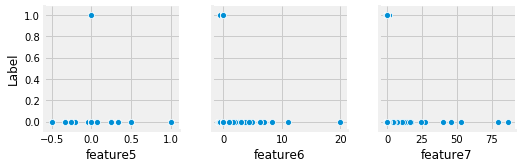

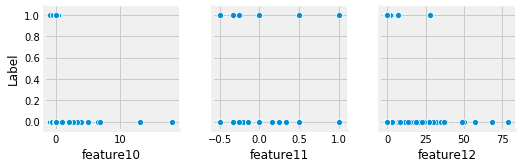

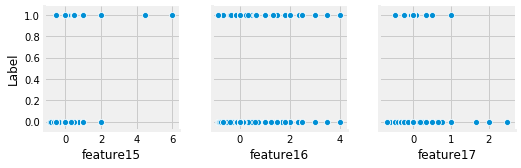

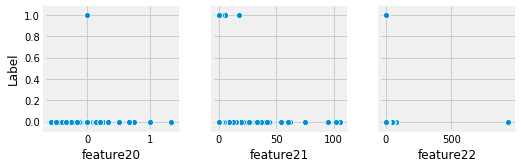

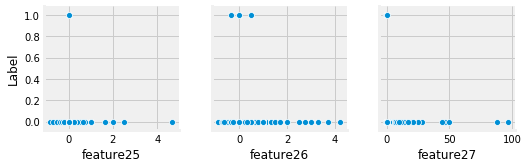

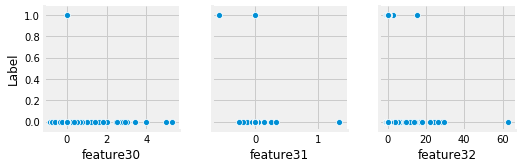

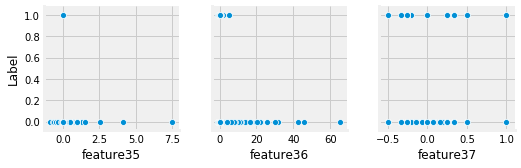

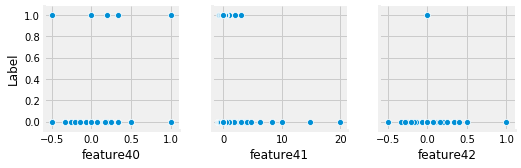

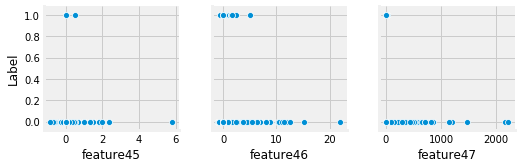

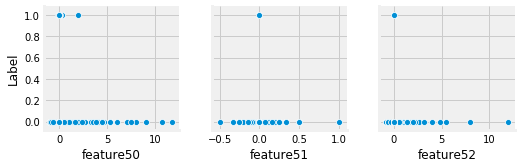

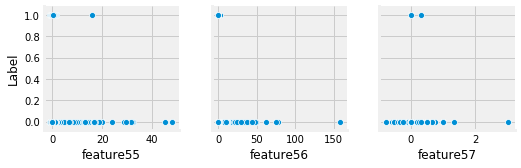

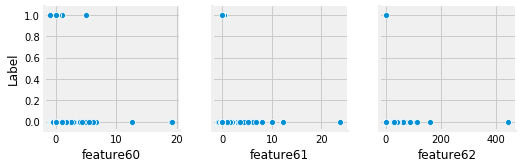

In [227]:
#Bi variate analysis
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i+1:i+4],
                y_vars=['Label'])

Above we saw that there are some clear values which are outliers
* Now lets see what about the variance of our features. 
  Are there features with very low variance ?

In [20]:
# Features with very low variance (there are 29 of them)
count = 0
low_var_col=[]
for i in counts[2]:
    if df_train[i].var()<0.01:
        low_var_col.append(i)
        count+=1
print(count)

29


Now lets start and make things a little interesting.
Lets see the feture importance of our variables. We ll do this using Random forest regressor.
1. We ll select our features and target variable and create a model and chart out their importance.

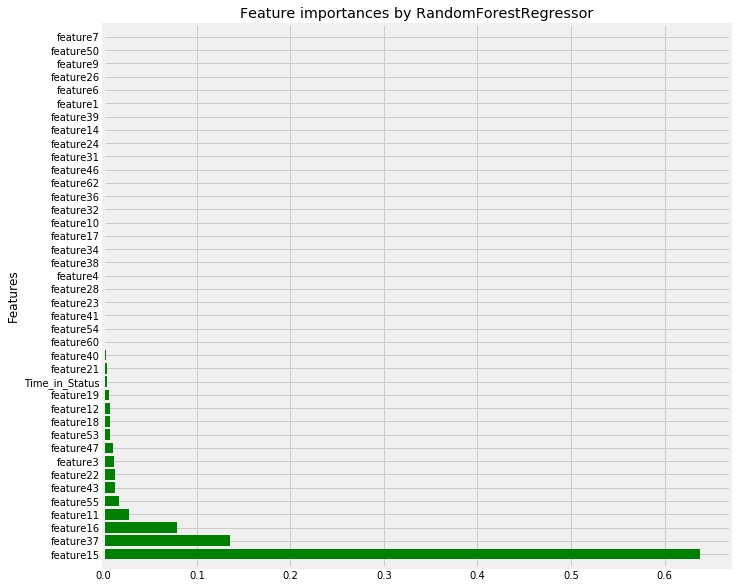

In [21]:
train_y = df_train['Label']
df_train.drop(['Label'],axis=1,inplace=True)
df_train.drop(['account_id','week_start_date'],axis=1,inplace=True)

train_X = df_train

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)
feature_names = train_X.columns.values

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:40]

plt.subplots(figsize=(10,10))
plt.title("Feature importances by RandomForestRegressor")
plt.ylabel("Features")
plt.barh(range(len(indices)), importances[indices], color="green", align="center")
plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal')
plt.ylim([-1, len(indices)])
plt.show()

Its very clear that feature 15 is really important while feature 37,16,11 and 55 also play a crucial role in churning effect.


Okay, now lets try out these two things:
1. Building a XGB model(considering we are treating each row independenlty), we ll consider each feature important(Vanilla model)
2. Building a XGB model with the selected 5 features and see the difference in the precision/recall crve of the above two.

In [ ]:
# df_train=df_train.set_index(['account_id','week_start_date'])

In [215]:
# Model right of the bat, no feature selection/Engineering

# Remove 'id' and 'target' columns
labels = df_train.columns[2:64]
# df_train.head()
X = df_train[labels]
y = df_train['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62
19126,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000
49534,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000
80339,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000
36621,0.0,0.0,0.492958,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,-0.166667,0.0,0.200000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000
13991,0.0,0.0,-0.561151,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.000000,0.0,-0.200000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46301,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000
78943,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000
71902,0.0,0.0,2.392857,0.0,0.0,0.0,0.0,0.0,-0.375,0.0,...,0.500000,0.0,0.071429,0.0,0.0,0.003788,0.0,0.0,0.0,-0.0625
11084,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000


In [216]:
X_test = X_test.as_matrix()
X_train = X_train.as_matrix()

Accuracy this high can NEVER be trusted? You know why this is high? Coz its fake :P
Its fake coz its good with detecting those 0's in the Lable but fails to detect those 1's which are of importance.

In [217]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.37%


Trying to see the value distrubtion of target

In [32]:
target_count =df_train.Label.value_counts()
print(target_count[0],target_count[1])

113630 1076


1. Plotting the confusion matrix of the Vanilla model 
2. Plotting the precision recall curve of the model.

Confusion matrix:
 [[22719     0]
 [    0   223]]


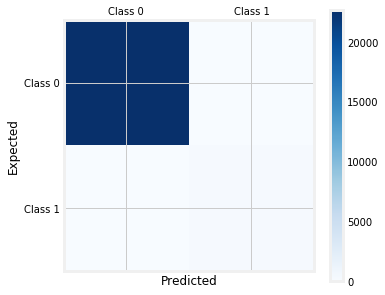

In [34]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

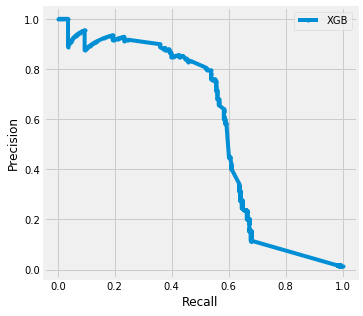

In [218]:
from sklearn.metrics import precision_recall_curve
# X=X.values
# y=y.values
# model.fit(X_train,y_train)
probx=model.predict_proba(X_test)
# probx
p,r,_=precision_recall_curve(y_test,probx[:,1])
plt.plot(r, p, marker='.', label='XGB')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()


Well, well, it doesnt look bad on the test set. But it takes into account the entire 62 features. I am pretty sure they dont all weigh in the same kind of value.
1. Lets try the important features out.

In [225]:
from sklearn.metrics import precision_recall_curve
# X=X.values
# y=y.values
from sklearn.model_selection import RepeatedStratifiedKFold
X_imp=df_train[['feature15','feature37','feature16','feature11','feature55']]
y_imp= df_train['Label']

X_train, X_test, y_train, y_test = train_test_split(X_imp, y_imp, test_size=0.2, random_state=1)

model_tuning = XGBClassifier()
# define grid
weights = [10]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model_tuning, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']



Best: 0.804822 using {'scale_pos_weight': 10}


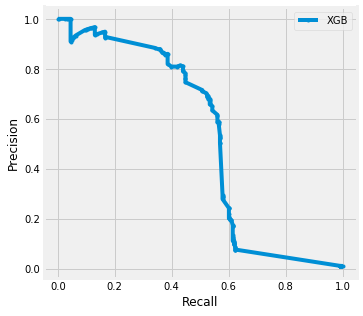

In [226]:
X_test = X_test.as_matrix()
X_train = X_train.as_matrix()
model_tuning.fit(X_train,y_train)
probx=model_tuning.predict_proba(X_test)
# probx
p,r,_=precision_recall_curve(y_test,probx[:,1])
plt.plot(r, p, marker='.', label='XGB')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

As its quite clear above, there is a slight dip in the precision value accross 0.6 recall but nonetheless, model shows potential if we select the 5 imporatant featues.

In [233]:
import pickle
file_name = "xgb_reg.pkl"

# saving the model
pickle.dump(model_tuning, open(file_name, "wb"))

 ## Splitting and Preprocessing 

Before we dive into Sampling(Random under and SMOTe). Let me clear of what went wrong and how to work around it.

1. The idea is when we do Sampling, we do split our dataset. BUT, the model needs to be tested on the ACTUAL testing set and not the sampled out testing set. We have to test our model(which btw, is FITTED on the sampled out data) on the actual test set.

In [172]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Churn', round(df_train['Label'].value_counts()[0]/len(df_train) * 100,2), '% of the dataset')
print('Churn', round(df_train['Label'].value_counts()[1]/len(df_train) * 100,2), '% of the dataset')

X = df_train.drop('Label', axis=1)
# X=df_train.drop('Time')
y = df_train['Label']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    
# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Churn 99.06 % of the dataset
Churn 0.94 % of the dataset
Train: [ 22894  22895  22896 ... 114703 114704 114705] Test: [    0     1     2 ... 27072 27073 27074]
Train: [     0      1      2 ... 114703 114704 114705] Test: [22894 22895 22896 ... 45881 45882 45883]
Train: [     0      1      2 ... 114703 114704 114705] Test: [45824 45884 45885 ... 68919 68920 68921]
Train: [     0      1      2 ... 114703 114704 114705] Test: [62986 62988 62990 ... 91923 91924 91925]
Train: [    0     1     2 ... 91923 91924 91925] Test: [ 78169  78171  78310 ... 114703 114704 114705]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99061734 0.00938266]
[0.99062813 0.00937187]


In [92]:
a=np.isnan(original_Xtest)
original_Xtest[a]=0

In [107]:
a=np.isnan(original_Xtrain)
original_Xtrain[a]=0

Splitting our data into 1076 values because we want to undersample and randomly. You might see that there are only 1042 Label values because there are only these many unique 1's in the data.

In [38]:
# amount of churn classes 1076 rows.
churn_df = new_df.loc[new_df['Label'] == 1]
non_churn_df = new_df.loc[new_df['Label'] == 0][:1076]
print(len(churn_df),len(non_churn_df))
normal_distributed_df = pd.concat([churn_df, non_churn_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

1042 1076


Lets plot out how does our distribution looks now !

Distribution of the Classes in the subsample dataset
0    0.508026
1    0.491974
Name: Label, dtype: float64


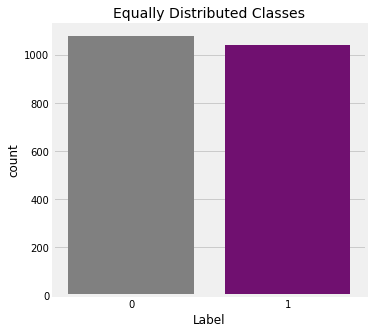

In [39]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Label'].value_counts()/len(new_df))



sns.countplot('Label', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

Alright, now lets try and see some correlation, we ll ensure that we work on subsample for our correlation.

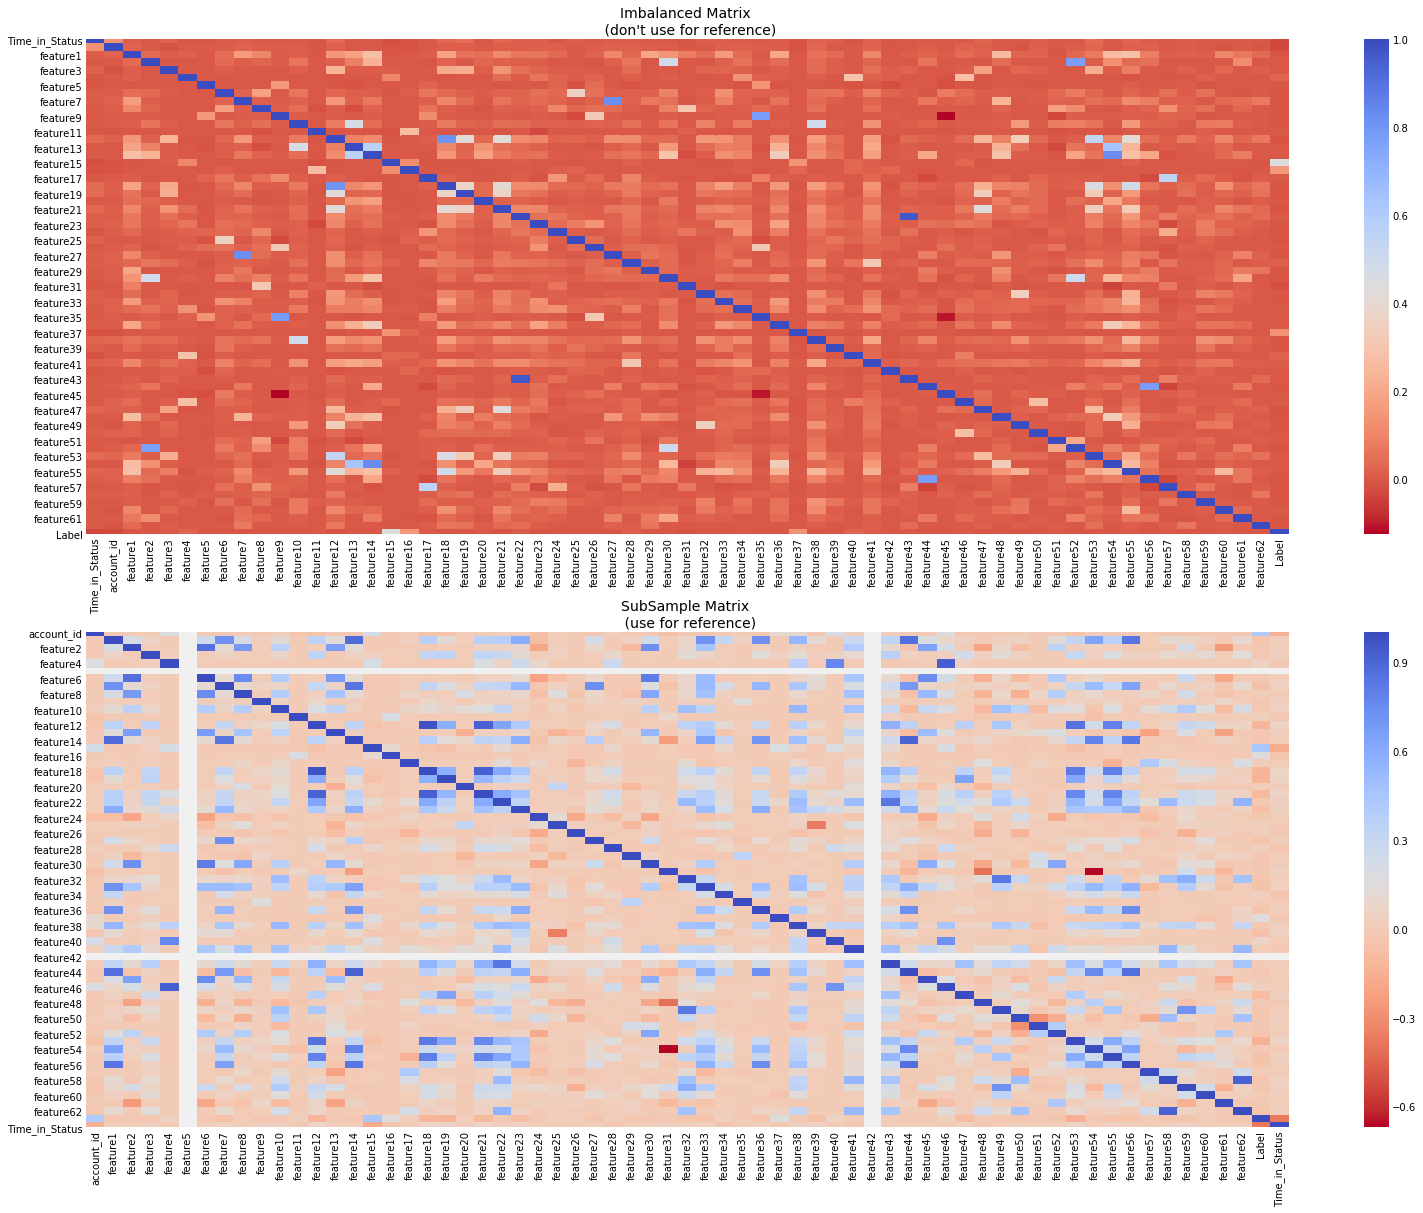

In [254]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df_train.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Matrix \n (use for reference)', fontsize=14)
plt.show()

Now, New_df is from the random undersample data (fewer instances)

In [44]:
# Dimensionality reduction 
# X= new_df.drop(['account_id','Time_in_Status','Label'],axis=1)
X
y = new_df['Label']
# X= X.drop('week_start_date',axis=1)

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

T-SNE took 2.2e+01 s
PCA took 0.023 s


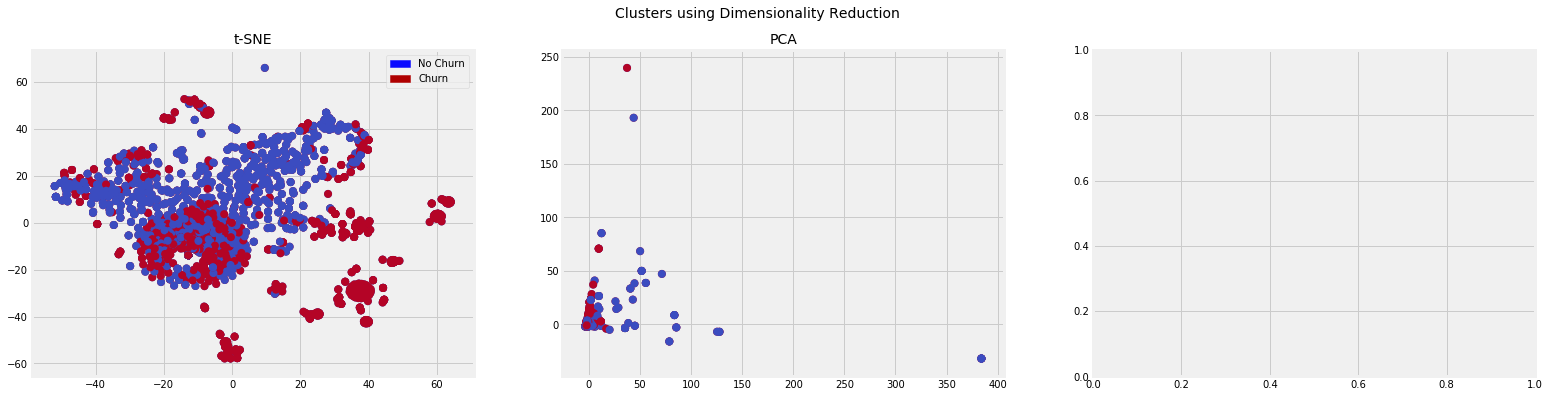

In [45]:
f, (ax1, ax2,_) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Churn', 'Churn']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Churn')
red_patch = mpatches.Patch(color='#AF0000', label='Churn')


# # t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Churn', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Churn', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Churn', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Churn', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

plt.show()

As I tried my hands on T-sne, I see there is some sort of distinctive clusters for churn and nonchurn, but one cluster clearly overlaps. So we are not really sure how to use this right now.

Now learning from the WRONG approach. I undersampled the data before cross validating it and ended up with an excellent accuracy. Turns out it introduces high variance. Hence the correct way is to sample and cross validate at the same time !

In [121]:
# Undersampling before Cross validating( Wrong way - high variance)

from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

Above we split the data and now we Model 4 distinctive models and try to see there accuracy scores. 

In [48]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 72.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 79.0 % accuracy score
Classifiers:  SVC Has a training score of 68.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 84.0 % accuracy score


In [49]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_
# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

Above we applied, GRidSearchCV to find the best parameters in our model tuning process.

In [50]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  72.14%
Knears Neighbors Cross Validation Score 80.34%
Support Vector Classifier Cross Validation Score 74.62%
DecisionTree Classifier Cross Validation Score 81.88%


Well the model above seems to be too good, but I made a mistake as I mentioned and this will be verified really son in the precision recall curve :)

In [76]:
# We will undersample during cross validating
# undersample_X = df_train.drop('Label', axis=1)
# undersample_y = df_train['Label']


for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []
# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# # Cross Validating the right way

# for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
#     undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
#     undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
#     undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
#     undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
#     undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
#     undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
#     undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
#     undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 22894  22895  22896 ... 114703 114704 114705] Test: [    0     1     2 ... 27072 27073 27074]
Train: [     0      1      2 ... 114703 114704 114705] Test: [22894 22895 22896 ... 45881 45882 45883]
Train: [     0      1      2 ... 114703 114704 114705] Test: [45824 45884 45885 ... 68919 68920 68921]
Train: [     0      1      2 ... 114703 114704 114705] Test: [62986 62988 62990 ... 91923 91924 91925]
Train: [    0     1     2 ... 91923 91924 91925] Test: [ 78169  78171  78310 ... 114703 114704 114705]
NearMiss Label Distribution: Counter({0: 1076, 1: 1076})


Apart from Precision recall , I try to see the ROC-AUC curve. How does it pans out and how much area does it cover.

In [79]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [80]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.7645645758721871
KNears Neighbors:  0.8052989479086476
Support Vector Classifier:  0.7549013455166181
Decision Tree Classifier:  0.8216088741618415


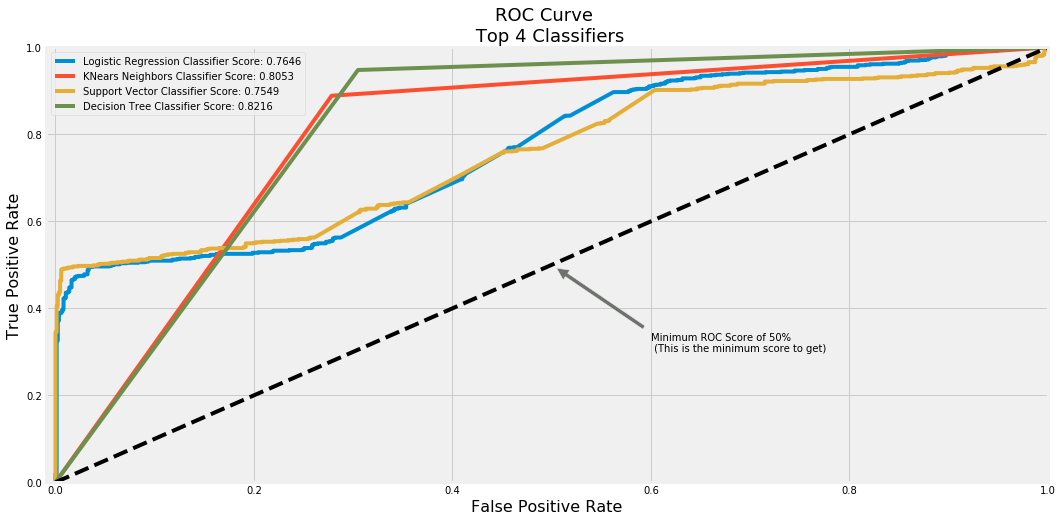

In [81]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

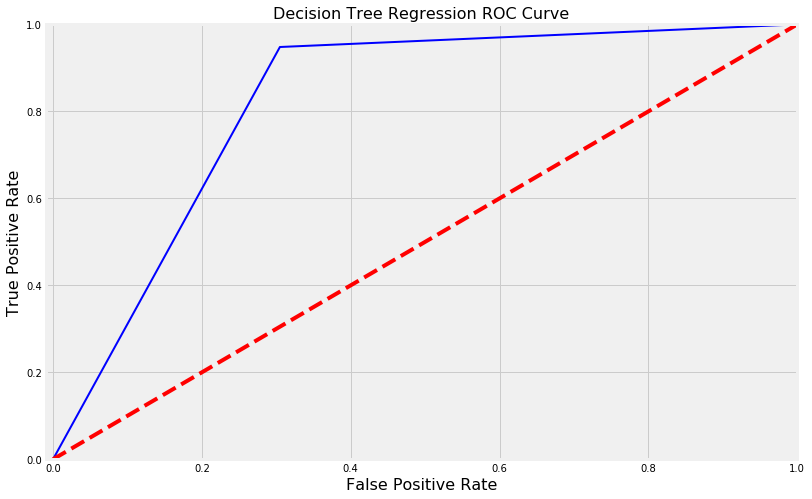

In [83]:
def dt_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Decision Tree Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
dt_curve(tree_fpr, tree_tpr)
plt.show()

Well, down below I try to show you that though Logistic regression gave us some decent accuracy, it failed miserably in measuring the precision recall. 

In [87]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [103]:
undersample_y_score = log_reg.decision_function(original_Xtest[:,2:64])

In [104]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.02


### The avaerage is mere "0.02" !!!

Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.02')

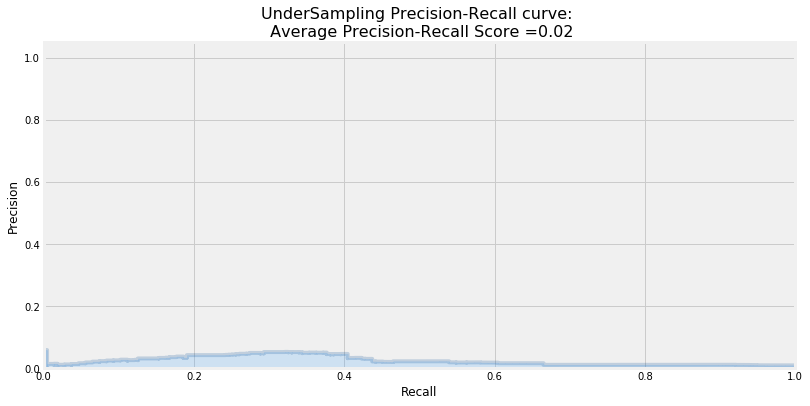

In [105]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

## Correct approach !


Alright enough with the mistakes, lets get down to some business and chart out the real model. with SMOTE sampling and cross validating at the same time.

In [108]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression(C=1, penalty='l2', solver='liblinear')

rand_log_reg = RandomizedSearchCV(LogisticRegression(C=1, penalty='l2', solver='liblinear'), log_reg_params, n_iter=4)

# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 91765 | Length of y (train): 91765
Length of X (test): 22941 | Length of y (test): 22941
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9802539094425979
precision: 0.32945403667018497
recall: 0.4692028498454093
f1: 0.35506248806736906
---------------------------------------------------------------------------------------------------------------------------------------


Lets see how the Classification report looks like:

In [109]:
labels = ['No Churn', 'Churn']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Churn       0.99      1.00      1.00     22726
       Churn       0.69      0.35      0.46       215

    accuracy                           0.99     22941
   macro avg       0.84      0.67      0.73     22941
weighted avg       0.99      0.99      0.99     22941



In [111]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.41


Tremendous imporvement in average precision-recall from 0.02 to 0.41

Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.41')

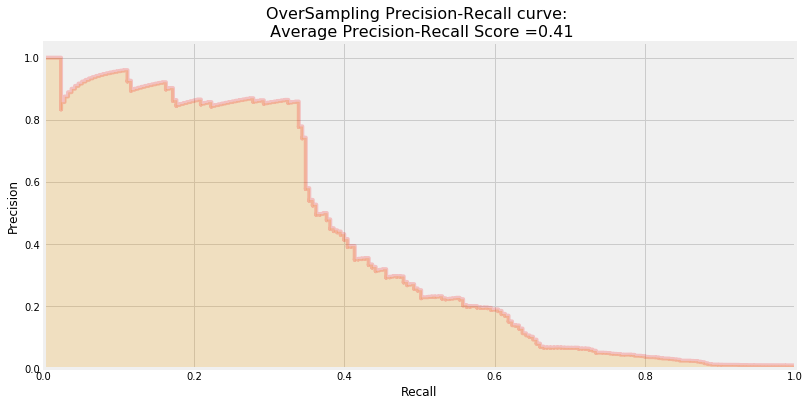

In [112]:
from sklearn.metrics import precision_recall_curve


y_score = best_est.decision_function(original_Xtest)
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='#F59B00')

plt.xlabel("Recall")
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

The model performed well on the test set and hence this seems to be the appropriate approach.

In [115]:
sm = SMOTE(random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)

# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [116]:
# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :1.0213007926940918 sec


## Below is Rough work and Please dont judge it, (feel free to look at it :)) and due to a limitation of time, I wasnt able to get good results from LSTM or Neural networks. 

Thus I choose to defend myself by saying:
    "Intrepetability of model is more important than a high modelling score for a data scientist :)"

In [155]:
import numpy as np 
import pandas as pd 
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

In [153]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

((1694, 62), (1694,), (424, 62), (424,))




In [156]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [157]:
undersample_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 62)                3906      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2016      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 5,988
Trainable params: 5,988
Non-trainable params: 0
_________________________________________________________________


In [158]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1355 samples, validate on 339 samples
Epoch 1/20





 - 4s - loss: 0.7306 - acc: 0.5823 - val_loss: 0.6467 - val_acc: 0.7109
Epoch 2/20
 - 0s - loss: 0.6166 - acc: 0.7269 - val_loss: 0.5909 - val_acc: 0.7316
Epoch 3/20
 - 0s - loss: 0.5596 - acc: 0.7424 - val_loss: 0.5293 - val_acc: 0.7434
Epoch 4/20
 - 1s - loss: 0.5019 - acc: 0.7572 - val_loss: 0.4898 - val_acc: 0.7493
Epoch 5/20
 - 1s - loss: 0.4613 - acc: 0.7535 - val_loss: 0.4950 - val_acc: 0.7670
Epoch 6/20
 - 0s - loss: 0.4461 - acc: 0.7727 - val_loss: 0.5382 - val_acc: 0.7611
Epoch 7/20
 - 0s - loss: 0.4288 - acc: 0.7875 - val_loss: 0.4413 - val_acc: 0.7965
Epoch 8/20
 - 1s - loss: 0.3989 - acc: 0.7941 - val_loss: 0.4818 - val_acc: 0.7788
Epoch 9/20
 - 0s - loss: 0.3909 - acc: 0.8074 - val_loss: 0.4874 - val_acc: 0.7876
Epoch 10/20
 - 0s - loss: 0.3736 - acc: 0.8170 - val_loss: 0.4496 - val_acc: 0.7935
Epoch 11/20
 - 0s - 

In [160]:
original_Xtest=original_Xtest[:,2:64]
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [161]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

In [162]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[21712  1014]
 [   87   128]]
Confusion matrix, without normalization
[[22726     0]
 [    0   215]]


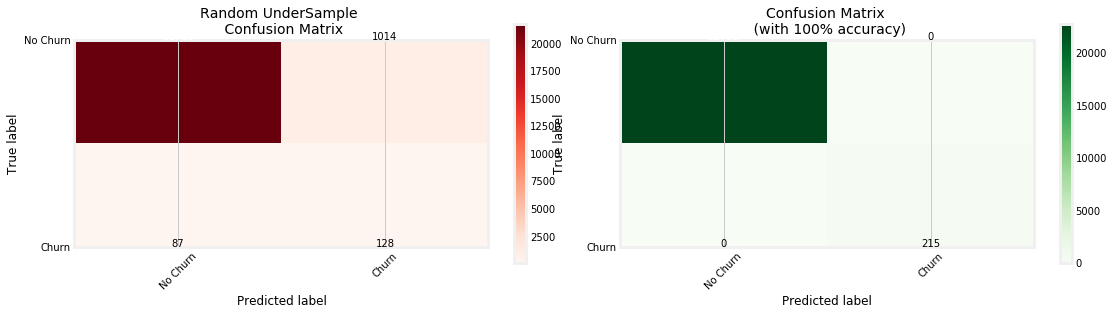

In [164]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Churn', 'Churn']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [165]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [166]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [167]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Train on 145446 samples, validate on 36362 samples
Epoch 1/20
 - 10s - loss: 10.0738 - acc: 0.3750 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/20
 - 5s - loss: 10.0738 - acc: 0.3750 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/20
 - 4s - loss: 10.0738 - acc: 0.3750 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/20
 - 5s - loss: 10.0738 - acc: 0.3750 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/20
 - 4s - loss: 10.0738 - acc: 0.3750 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 6/20
 - 5s - loss: 10.0738 - acc: 0.3750 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 7/20
 - 5s - loss: 10.0738 - acc: 0.3750 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 8/20
 - 4s - loss: 10.0738 - acc: 0.3750 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 9/20
 - 4s - loss: 10.0738 - acc: 0.3750 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 10/20
 - 4s - loss: 10.0738 - acc: 0.3750 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 11/20
 - 4s - loss: 10.0738 - acc: 0.3750 - val_loss: 1.1921e

In [173]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [174]:
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

Confusion matrix, without normalization
[[  836 21890]
 [    2   213]]
Confusion matrix, without normalization
[[22726     0]
 [    0   215]]


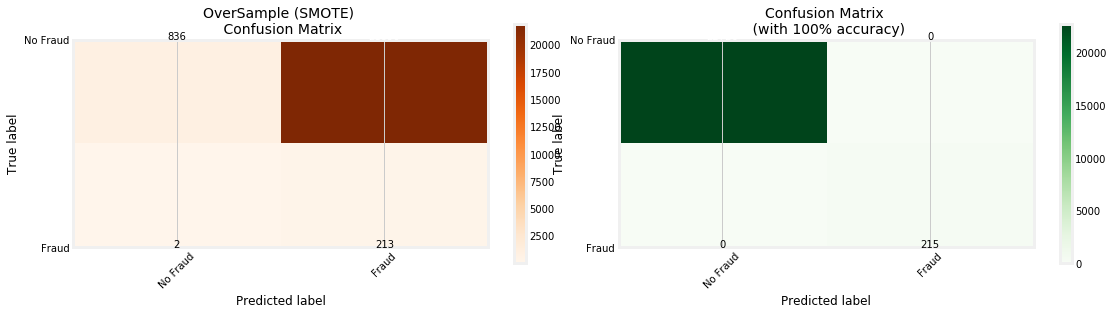

In [175]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [231]:
labels = df_test.columns[2:64]
# df_train.head()
X_true = df_train[labels]
y_true = df_train['Label']

In [250]:
# load
with open('xgb_reg.pkl', 'rb') as file:  
    xgb_model_loaded = pickle.load(file)